<h1><center>Ügyféllemorzsolódás elemzés és előrejelzés gépi tanulási algoritmusokkal</center></h1>

## Tartalomjegyzék

1. [Bevezetés](#Bevezetés)
2. [Adatbetöltés, tisztítás és vizsgálat](#Adatbetöltés-tisztítás-és-vizsgálat)
3. [Vizualizációk, elemzések](#Vizualizációk-elemzések)
4. [Modellépítés és értékelés](#Modellépítés-és-kiértékelés)
5. [Összefoglalás és konklúzió](#Összefoglalás-konklúzió)

# Bevezetés

A banki ügyfelek lemorzsolódásának megértése és előrejelzése kritikus fontosságú az ügyfélmegtartás szempontjából. Jelen program egy fiktív bank adathalmazán alapul, amely az ügyféllemorzsolódás mögötti tényezőket vizsgálja. Az adatok alapos elemzését követően különböző gépi tanulási algoritmusok segítségével történik az előrejelzés, végül az elemzések és a modellek teljesítményének értékelése alapján üzleti szempontból releváns következtetések levonására kerül sor. A cél a lemorzsolódás kockázati tényezőinek azonosítása és hatékony megtartási stratégiák támogatása.

###### Adatbetöltés-tisztítás-és-vizsgálat

# Adatbetöltés, tisztítás és vizsgálat

### Szükséges könyvtárak importálása:

In [1]:
# Adatkezelés és feldolgozás
import pandas as pd
import numpy as np

# Sklearn komponensek
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold

# Felhasznált modellek
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Imbalanced-learn komponensek az osztályegyensúlyozáshoz 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  

# numerikus és bináris változók összefüggésének feltárásához
from scipy.stats import pointbiserialr, uniform, randint, chi2_contingency

# Vizualizációs könyvtárak
import matplotlib.pyplot as plt
import seaborn as sns


### Adatok áttekintése:

In [2]:
# Adatok betöltése
data = pd.read_csv('Churn_Modelling.csv')

# Az első néhány sor megtekintése
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
data.rename(columns={"Exited": "Churned"}, inplace=True)

In [4]:
# Az adatok típusainak és hiányzó értékek számának megtekintése
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Churned          10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
# Az adatok statisztikai összegzése 
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churned
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### Adattisztítás

#### Hiányzó értékek áttekintése:

In [6]:
missing_values = data.isnull().sum()

# Hiányzó értékek száma oszloponként
for column, missing_count in missing_values.items():
    print(f"Oszlop: {column}, Hiányzó értékek száma: {missing_count}")

Oszlop: RowNumber, Hiányzó értékek száma: 0
Oszlop: CustomerId, Hiányzó értékek száma: 0
Oszlop: Surname, Hiányzó értékek száma: 0
Oszlop: CreditScore, Hiányzó értékek száma: 0
Oszlop: Geography, Hiányzó értékek száma: 0
Oszlop: Gender, Hiányzó értékek száma: 0
Oszlop: Age, Hiányzó értékek száma: 0
Oszlop: Tenure, Hiányzó értékek száma: 0
Oszlop: Balance, Hiányzó értékek száma: 0
Oszlop: NumOfProducts, Hiányzó értékek száma: 0
Oszlop: HasCrCard, Hiányzó értékek száma: 0
Oszlop: IsActiveMember, Hiányzó értékek száma: 0
Oszlop: EstimatedSalary, Hiányzó értékek száma: 0
Oszlop: Churned, Hiányzó értékek száma: 0


#### Nincsenek hiányzó értékek

#### Duplikátumok vizsgálata:

In [7]:
# Duplikált sorok vizsgálata
duplicates = data.duplicated().sum()
print(f"Duplikált sorok száma: {duplicates}")

Duplikált sorok száma: 0


#### Nincsenek duplikátumok

#### Felesleges oszlopok eltávolítása:

In [8]:
# Felesleges oszlopok eltávolítása
data_cleaned = data.drop(columns=["RowNumber", "CustomerId", "Surname"], errors="ignore")
print("Az adatok mérete a fölösleges oszlopok eltávolítása után:", data_cleaned.shape)

# Az eredmény ellenőrzése
data_cleaned.head()

Az adatok mérete a fölösleges oszlopok eltávolítása után: (10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Numerikus változók áttekintése

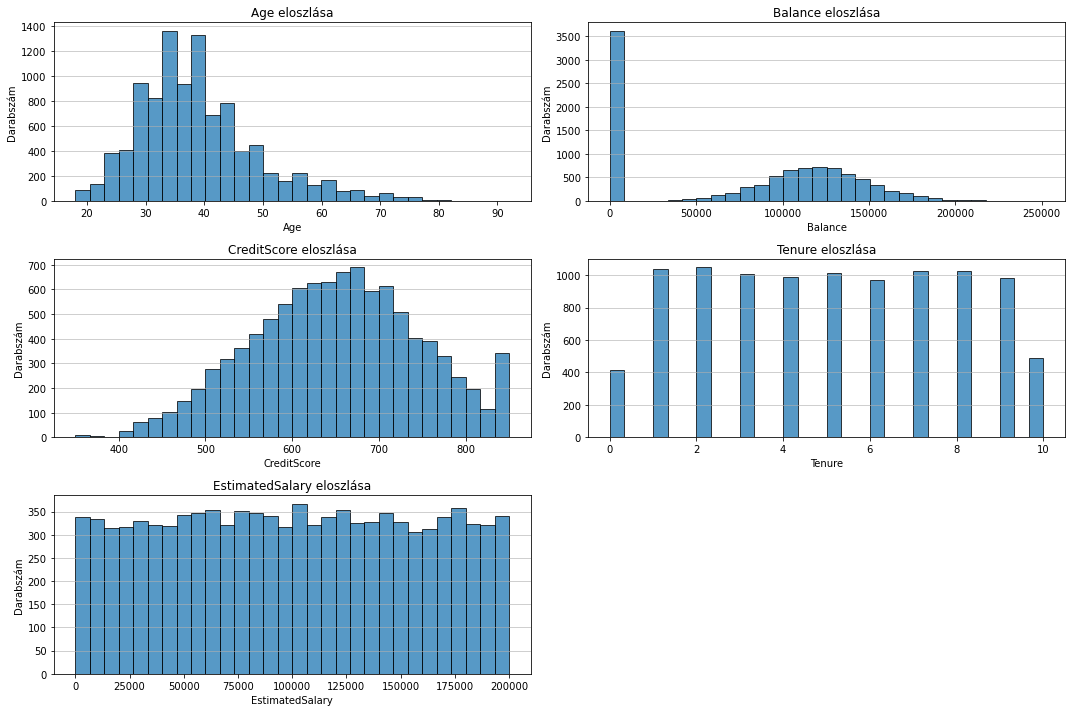

In [9]:
numerical_columns = ["Age", "Balance", "CreditScore", "Tenure", "EstimatedSalary"]

# Histogrammok megjelenítése
plt.figure(figsize=(15, 10))  # Ábra mérete
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 2, i)  # Több ábrát egymás mellé rendezése
    plt.hist(data_cleaned[column], bins=30, alpha=0.75, edgecolor="black")  # Hisztogram beállítások
    plt.title(f"{column} eloszlása")
    plt.xlabel(column)
    plt.ylabel("Darabszám")
    plt.grid(axis="y", alpha=0.75)  # Segédvonalak az Y tengelyen

plt.tight_layout() 
plt.show()

### Kategorikus változók áttekintése

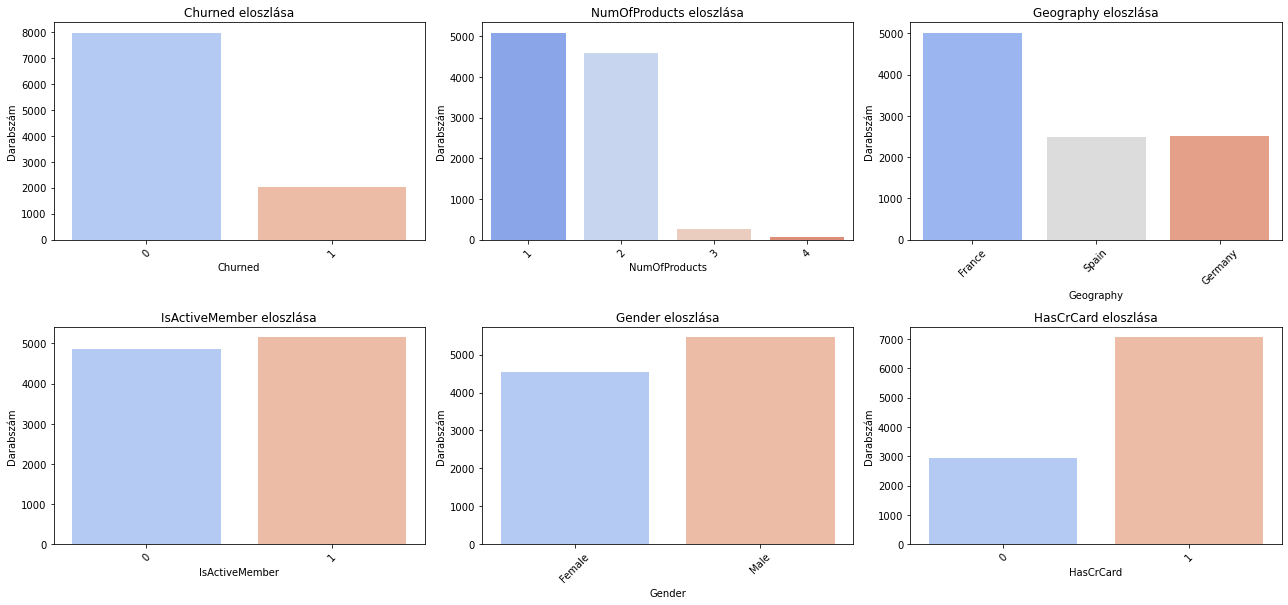

In [10]:
# Kategorikus változók listája
categorical_columns = ["Churned", "NumOfProducts", "Geography", "IsActiveMember", "Gender", "HasCrCard"]

# Ábra mérete és alábrázolások száma
plt.figure(figsize=(18, 12))
num_columns = 3  # Egy sorban helyet kapó oszlop száma

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns) // num_columns + 1, num_columns, i)
    sns.countplot(data=data_cleaned, x=column, palette="coolwarm")
    plt.title(f"{column} eloszlása")
    plt.xlabel(column)
    plt.ylabel("Darabszám")
    plt.xticks(rotation=45)  # Forgatás, ha túl sok kategória lenne

plt.tight_layout()  # Az ábrák közötti hely optimalizálása
plt.show()


### Kilógó értékek vizsgálata

In [11]:
def calculate_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    return outliers.sum()

outlier_counts = calculate_outliers(data_cleaned)
print("Kilógó értékek oszloponként:")
print(outlier_counts)

Kilógó értékek oszloponként:
Age                 359
Balance               0
Churned            2037
CreditScore          15
EstimatedSalary       0
Gender                0
Geography             0
HasCrCard             0
IsActiveMember        0
NumOfProducts        60
Tenure                0
dtype: int64


<ipython-input-11-32c6d7025ad8>:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
<ipython-input-11-32c6d7025ad8>:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))


#### A kategorikus változók vizualizációjából látszik, hogy a Churned értékből jelentősen kevesebb van, ezek azonban nem valódi kilógó értékek, hasonló a helyzet a NumOfProducts változónál is, itt azonban érdemes megvizsgálni jobban a helyzetet:

In [12]:
data_cleaned.NumOfProducts.value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

#### Mivel a harmadik és negyedi kategoriából jóval kevesebb az érték, ezeket érdemes összevonni egy kategóriába (3+)

In [13]:
# 3+ kategória bevezetése
data_cleaned['NumOfProducts'] = data_cleaned['NumOfProducts'].apply(lambda x: str(x) if x <= 2 else "3+")
data_cleaned.NumOfProducts.value_counts()

1     5084
2     4590
3+     326
Name: NumOfProducts, dtype: int64

In [14]:
outlier_counts = calculate_outliers(data_cleaned)
print("Kilógó értékek oszloponként:")
print(outlier_counts)

Kilógó értékek oszloponként:
Age                 359
Balance               0
Churned            2037
CreditScore          15
EstimatedSalary       0
Gender                0
Geography             0
HasCrCard             0
IsActiveMember        0
NumOfProducts         0
Tenure                0
dtype: int64


<ipython-input-11-32c6d7025ad8>:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
<ipython-input-11-32c6d7025ad8>:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))


In [15]:
# Kilógó értékek listázása
columns_with_outliers = outlier_counts[outlier_counts > 0].index.tolist()

# A Churned jellemzőt kihagyása a vizualizációból, mivel ez nem numerikus változó
columns_with_outliers.remove("Churned")

#### Vizsgáljuk meg a numerikus változók kilógó értékeit doboz diagrammal

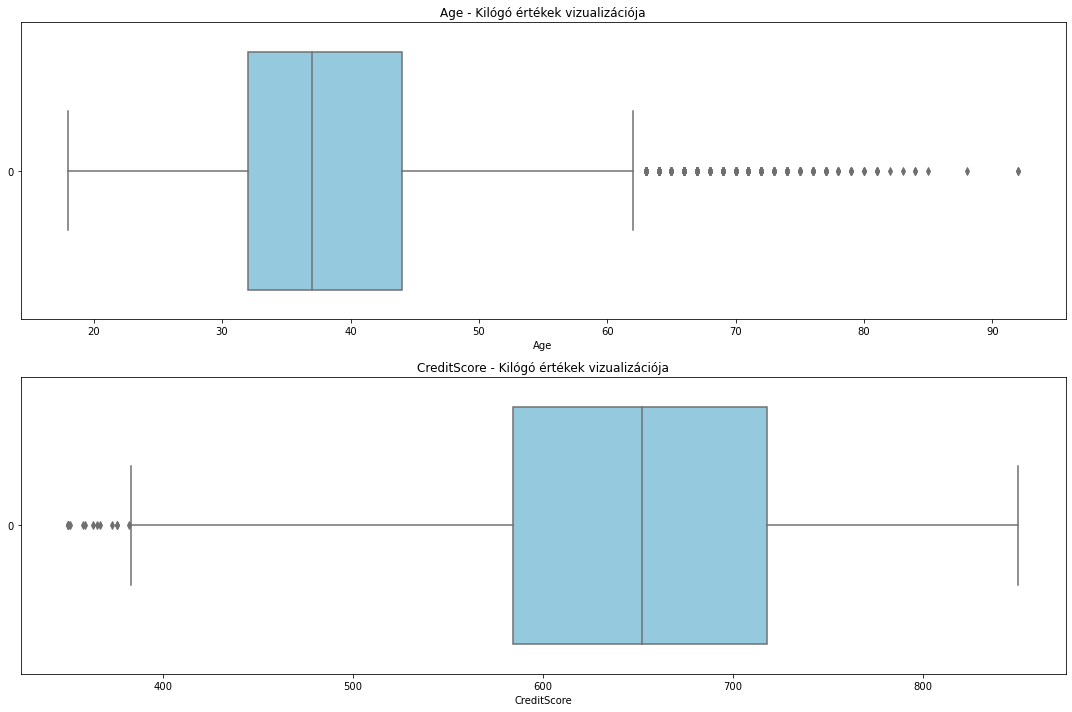

In [16]:
# Boxplotok megjelenítése
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_with_outliers, 1):
    plt.subplot(len(columns_with_outliers), 1, i)
    sns.boxplot(data=data_cleaned[column], orient="h", color="skyblue")
    plt.title(f"{column} - Kilógó értékek vizualizációja")
    plt.xlabel(column)

plt.tight_layout()
plt.show()

#### Bár vannak kilógó értékek, ezek mennyisége nem számottevő, továbbá ezek nem irreálisak szélsőségesek (nem adatfelvételi hibára utalnak), csak az eloszlásukból adódóan esnek kívül az alsó, vagy felső kerítésen, így ezek eltávolítása nem volt szükséges.

###### Vizualizációk-elemzések 

 <h1><center>Vizualizációk, elemzések</center></h1>

###  Lemorzsolódott és megmaradt ügyfelek arányának vizsgálata

Churn és not churned arány:
0    7963
1    2037
Name: Churned, dtype: int64


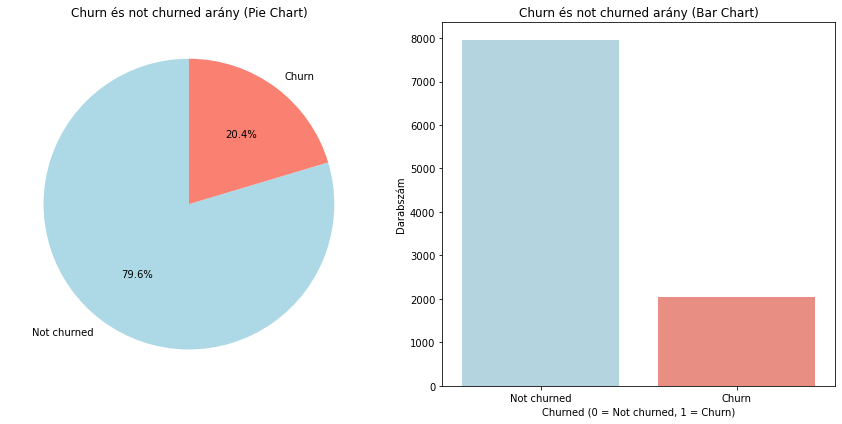

In [17]:
# Lemorzsolódási arány kiszámítása
churn_counts = data_cleaned["Churned"].value_counts()
print("Churn és not churned arány:")
print(churn_counts)

# Rácsos elrendezés létrehozása az egymás melletti ábrákhoz
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Bal oldali ábra: Pie chart
axes[0].pie(
    churn_counts, 
    labels=["Not churned", "Churn"], 
    autopct="%1.1f%%", 
    startangle=90, 
    colors=["lightblue", "salmon"]
)
axes[0].set_title("Churn és not churned arány (Pie Chart)")

# Jobb oldali ábra: Oszlopdiagram
sns.countplot(data=data_cleaned, x="Churned", ax=axes[1], palette=["lightblue", "salmon"])
axes[1].set_title("Churn és not churned arány (Bar Chart)")
axes[1].set_xlabel("Churned (0 = Not churned, 1 = Churn)")
axes[1].set_ylabel("Darabszám")
axes[1].set_xticklabels(["Not churned", "Churn"])

# Automatikus elrendezés
plt.tight_layout()
plt.show()


#### Az adathalmaz lemorzsolódás szempontjából nem kiegyenlített, jelentősen több a megmaradt ügyfelek aránya (majdnem 80 %)

### Kategorikus változók hatása a lemorzsolódásra

Khi-négyzet teszt eredményei:
          Változó         Chi2       P-érték
0   NumOfProducts  1494.603266  0.000000e+00
1       Geography   301.255337  3.830318e-66
2  IsActiveMember   242.985342  8.785858e-55
3          Gender   112.918571  2.248210e-26
4       HasCrCard     0.471338  4.923724e-01


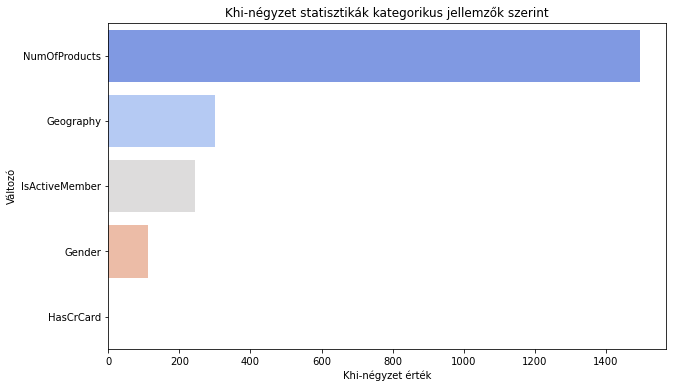

In [18]:
# Kategorikus változók listája
categorical_columns = ["NumOfProducts", "Geography", "IsActiveMember", "Gender", "HasCrCard"]

# Khi-négyzet statisztika tárolásához
chi2_results = []

for column in categorical_columns:
    # Kontingenciatábla létrehozása
    contingency_table = pd.crosstab(data_cleaned[column], data_cleaned["Churned"])
    
    # Khi-négyzet teszt végrehajtása
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Eredmények mentése
    chi2_results.append({"Változó": column, "Chi2": chi2, "P-érték": p})

# Khi-négyzet eredmények DataFrame
chi2_df = pd.DataFrame(chi2_results).sort_values(by="Chi2", ascending=False)

# Eredmények kiírása
print("Khi-négyzet teszt eredményei:")
print(chi2_df)

# Vizualizáció
plt.figure(figsize=(10, 6))
sns.barplot(data=chi2_df, x="Chi2", y="Változó", palette="coolwarm")
plt.title("Khi-négyzet statisztikák kategorikus jellemzők szerint")
plt.xlabel("Khi-négyzet érték")
plt.ylabel("Változó")
plt.show()

 A Khi-négyzet teszt alapján az öt kategorikus változóból négy  szignifikánsan befolyásolja a lemorzsolódást. A legjelentősebb hatást a NumOfProducts (használt termékek száma) mutatta, ezt követte a Geography (földrajzi elhelyezkedés), az IsActiveMember (aktivitási státusz) és a Gender (nem). A HasCrCard (hitelkártya megléte) nem mutatott szignifikáns hatást

### Vizualizációk a kategórikus változókra

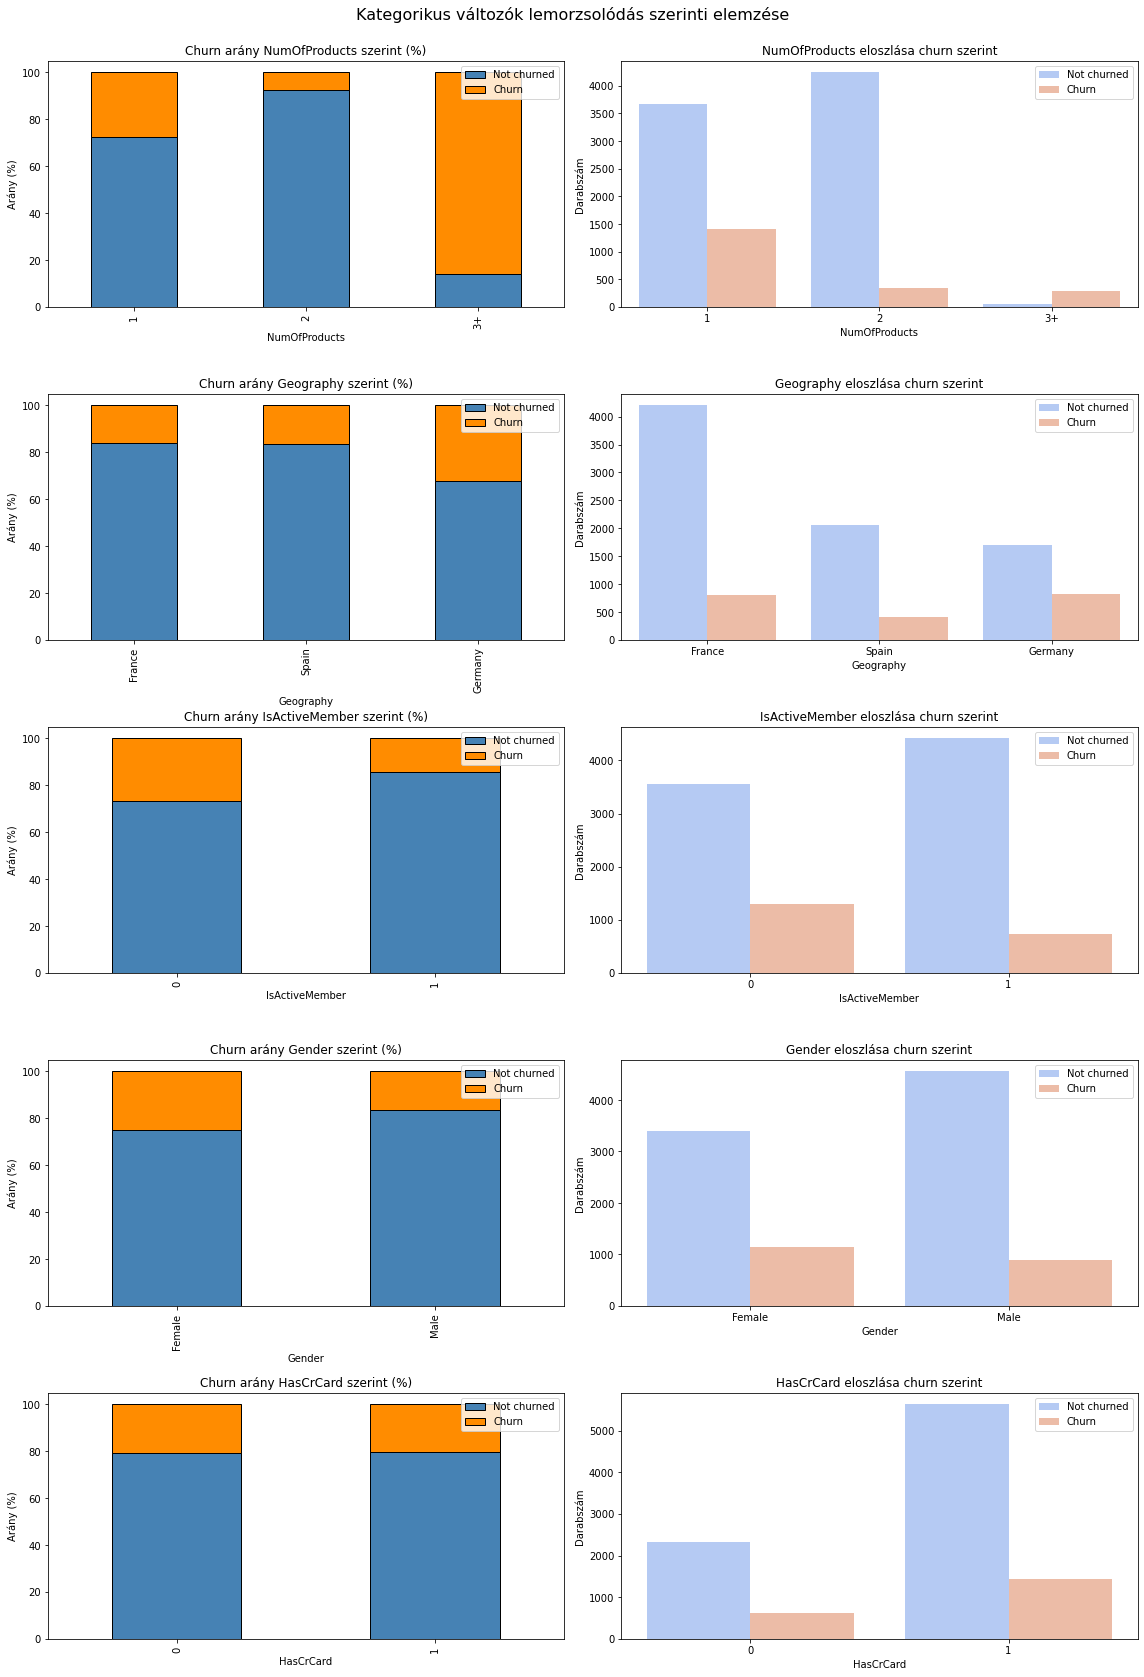

In [19]:
# Vizsgálni kívánt kategorikus változók listája

# Geography sorrendjének beállítása
data_cleaned["Geography"] = pd.Categorical(
    data_cleaned["Geography"], categories=["France", "Spain", "Germany"], ordered=True
)

# NumOfProducts kategóriák sorrendjének beállítása
data_cleaned["NumOfProducts"] = pd.Categorical(
    data_cleaned["NumOfProducts"], categories=["1", "2", "3+"], ordered=True
)

# Ábrák rácsos elrendezése
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=2, figsize=(16, 5 * len(categorical_columns)))
fig.suptitle("Kategorikus változók lemorzsolódás szerinti elemzése", fontsize=16, y=0.93)

for i, column in enumerate(categorical_columns):
    # Százalékos arány kiszámítása lemorzsolódás alapján
    churn_pct = (
        data_cleaned.groupby(column)["Churned"]
        .value_counts(normalize=True)
        .unstack(fill_value=0) * 100
    )
    churn_pct.columns = ["Not churned (%)", "Churn (%)"]
    
    # Bal oldali: halmozott oszlopdiagram (százalékos arányok)
    churn_pct.plot(kind="bar", stacked=True, ax=axes[i, 0], color=["steelblue", "darkorange"], edgecolor="black")
    axes[i, 0].set_title(f"Churn arány {column} szerint (%)")
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel("Arány (%)")
    axes[i, 0].legend(["Not churned", "Churn"], loc="upper right")
    
    # Jobb oldali: countplot (darabszámok)
    sns.countplot(data=data_cleaned, x=column, hue="Churned", palette="coolwarm", ax=axes[i, 1])
    axes[i, 1].set_title(f"{column} eloszlása churn szerint")
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel("Darabszám")
    axes[i, 1].legend(["Not churned", "Churn"], loc="upper right")

# Automatikusan illeszkedjenek az ábrák
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Az egyik legfontosabb tényező az ügyfél által használt banki termékek száma. Érdekes módon azok, akik három vagy több terméket vesznek igénybe jóval kevesebben vannak, azonban sokkal nagyobb valószínűséggel távoznak, mint akik csak egyet vagy kettőt. Ez arra utalhat, hogy a termékek összetettsége vagy talán ezek költségei túl magasak lehetnek számukra.

A földrajzi elhelyezkedést vizsgálva látható, hogy Németországban az ügyfelek hajlamosabbak lemorzsolódni, míg Franciaországban és Spanyolországban ez kevésbé van jelen. Ennek oka lehet a kulturális vagy gazdasági különbségek, érdemes lehet itt egy más marketing megközelítést alkalmazni.

Az aktív ügyfelek körében a lemorzsolódás arány jelentősen alacsonyabb, míg az inaktív ügyfelek jelentős része elhagyja a bankot. Ez kiemeli az aktivitás ösztönzésének fontosságát az ügyfélmegtartási stratégiákban, logikusan akik gyakrabban használják a bank szolgáltatásait, nagyobb eséllyel maradnak hűséges felhasználók.

A nemek közötti különbségek kisebb eltérést mutat, de a férfiak valamivel nagyobb arányban távoznak, mint a nők. Érdemes lehet esetlegesen inkább a férfi ügyfeleket célzó termékeket vagy hirdetéseket kidolgozni

Látható, hogy valóban nincs érdemi különbség lemorzsolódási arányt tekintve a hitelkártya meglétét vizsgálva, gyakorlatilag megegyezik a ezen két érték.

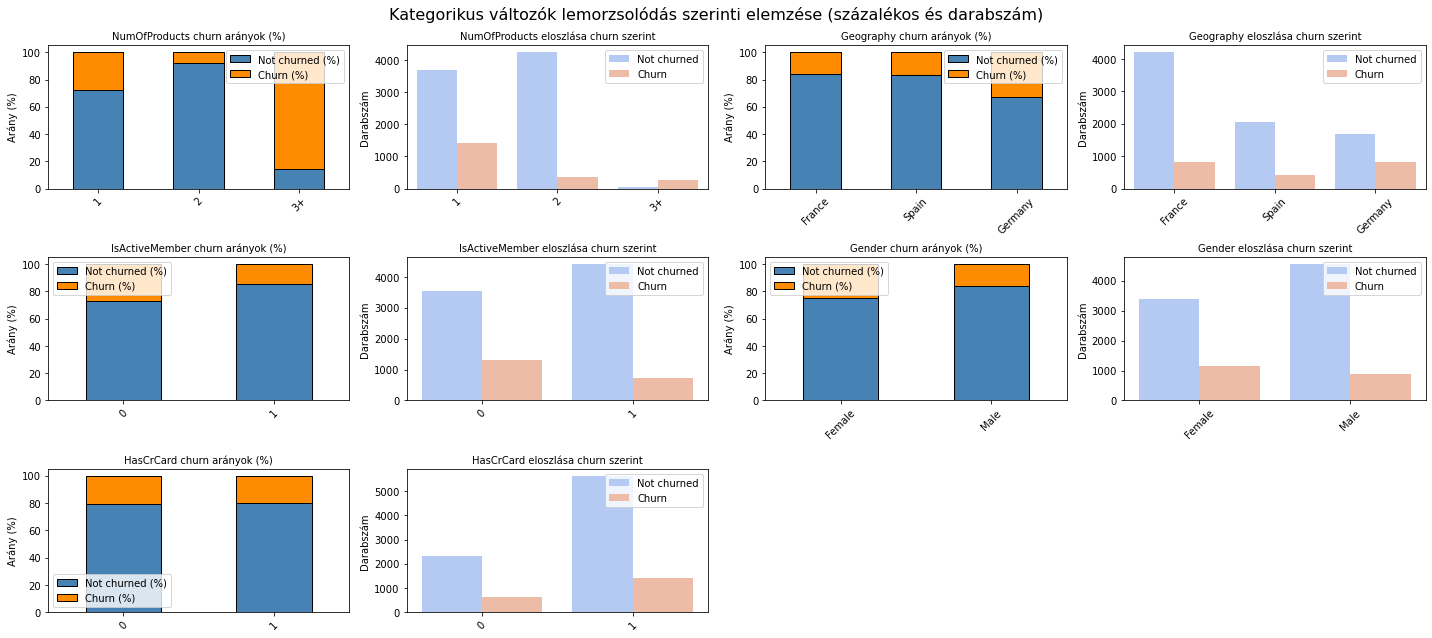

In [20]:
# Elrendezés egy kisebb ábrára

# Ábrák rácsos elrendezése (4 diagram egy sorban)
cols = 4  # Egy sorban lévő diagramok száma
rows = -(-len(categorical_columns) // (cols // 2))  # Sorok száma, 2 ábra per változó
fig, axes = plt.subplots(rows, cols, figsize=(20, 3 * rows))  # Méret csökkentése
axes = axes.flatten()  # Tengelyek laposítása egyszerűbb hozzáféréshez

# Ábrák generálása
for i, column in enumerate(categorical_columns):
    # Százalékos arány kiszámítása lemorzsolódás alapján
    churn_pct = (
        data_cleaned.groupby(column)["Churned"]
        .value_counts(normalize=True)
        .unstack(fill_value=0) * 100
    )
    churn_pct.columns = ["Not churned (%)", "Churn (%)"]
    
    # Bal oldali: százalékos oszlopdiagram
    churn_pct.plot(kind="bar", stacked=True, ax=axes[i * 2], color=["steelblue", "darkorange"], edgecolor="black")
    axes[i * 2].set_title(f"{column} churn arányok (%)", fontsize=10)
    axes[i * 2].set_xlabel("")
    axes[i * 2].set_ylabel("Arány (%)")
    axes[i * 2].tick_params(axis="x", rotation=45)
    
    # Jobb oldali: countplot (darabszámok)
    sns.countplot(data=data_cleaned, x=column, hue="Churned", palette="coolwarm", ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f"{column} eloszlása churn szerint", fontsize=10)
    axes[i * 2 + 1].set_xlabel("")
    axes[i * 2 + 1].set_ylabel("Darabszám")
    axes[i * 2 + 1].legend(["Not churned", "Churn"], loc="upper right")
    axes[i * 2 + 1].tick_params(axis="x", rotation=45)

# Üres tengelyek kikapcsolása, ha maradnak üres helyek
for ax in axes[len(categorical_columns) * 2:]:
    ax.remove()

# Automatikus elrendezés
plt.tight_layout()
plt.subplots_adjust(top=0.92)
fig.suptitle("Kategorikus változók lemorzsolódás szerinti elemzése (százalékos és darabszám)", fontsize=16)
plt.show()

### Korreláció számítás a numerikus változók közötti összefüggések feltárására

                 Correlation        P-value
Age                 0.285323  1.239931e-186
Balance             0.118533   1.275563e-32
EstimatedSalary     0.012097   2.264404e-01
Tenure             -0.014001   1.615268e-01
CreditScore        -0.027094   6.738214e-03


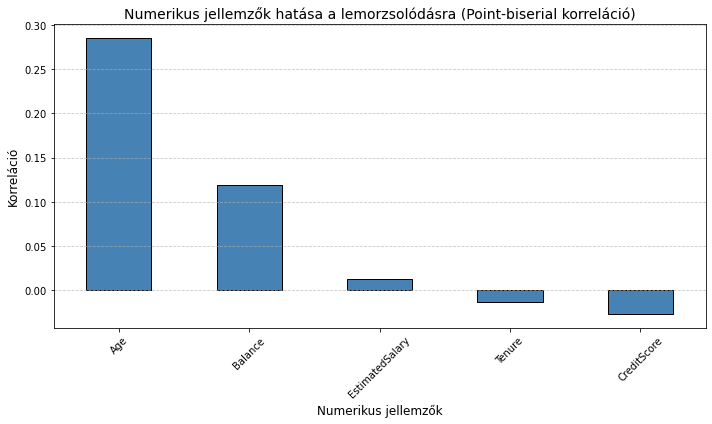

In [21]:
correlation_results = {}

for column in numerical_columns:
    correlation, p_value = pointbiserialr(data_cleaned[column], data_cleaned["Churned"])
    correlation_results[column] = {"Correlation": correlation, "P-value": p_value}

# Eredmények DataFrame-be konvertálása
correlation_df = pd.DataFrame(correlation_results).T.sort_values(by="Correlation", ascending=False)
print(correlation_df)

# Vizualizáció készítése a korrelációk alapján
plt.figure(figsize=(10, 6))
correlation_df["Correlation"].sort_values(ascending=False).plot(kind="bar", color="steelblue", edgecolor="black")
plt.title("Numerikus jellemzők hatása a lemorzsolódásra (Point-biserial korreláció)", fontsize=14)
plt.ylabel("Korreláció", fontsize=12)
plt.xlabel("Numerikus jellemzők", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

A fenti ábra alapján a numerikus jellemzők közül az Age (életkor) mutatja a legerősebb pozitív korrelációt a lemorzsolódással (0,285), ami azt jelzi, hogy az idősebb ügyfelek nagyobb valószínűséggel hagyják el a szolgáltatót. A Balance (számlaegyenleg) szintén pozitív korrelációt mutat (0,118), de kisebb mértékben, jelezve, hogy a magasabb egyenlegű ügyfelek érdekes módon hajlamosabbak a lemorzsolódásra.

A többi jellemző, mint az EstimatedSalary (becsült fizetés), Tenure (banknál eltöltött évek) és CreditScore (hitelpontszám), gyakorlatilag elhanyagolható korrelációt mutat a lemorzsolódással. Ezek az eredmények arra utalnak, hogy az életkor és a számlaegyenleg a legfontosabb numerikus tényezők, amelyeket figyelembe kell venni az ügyfélmegtartási stratégiák kidolgozásakor.

### Vizualizációk a numerikus változókra

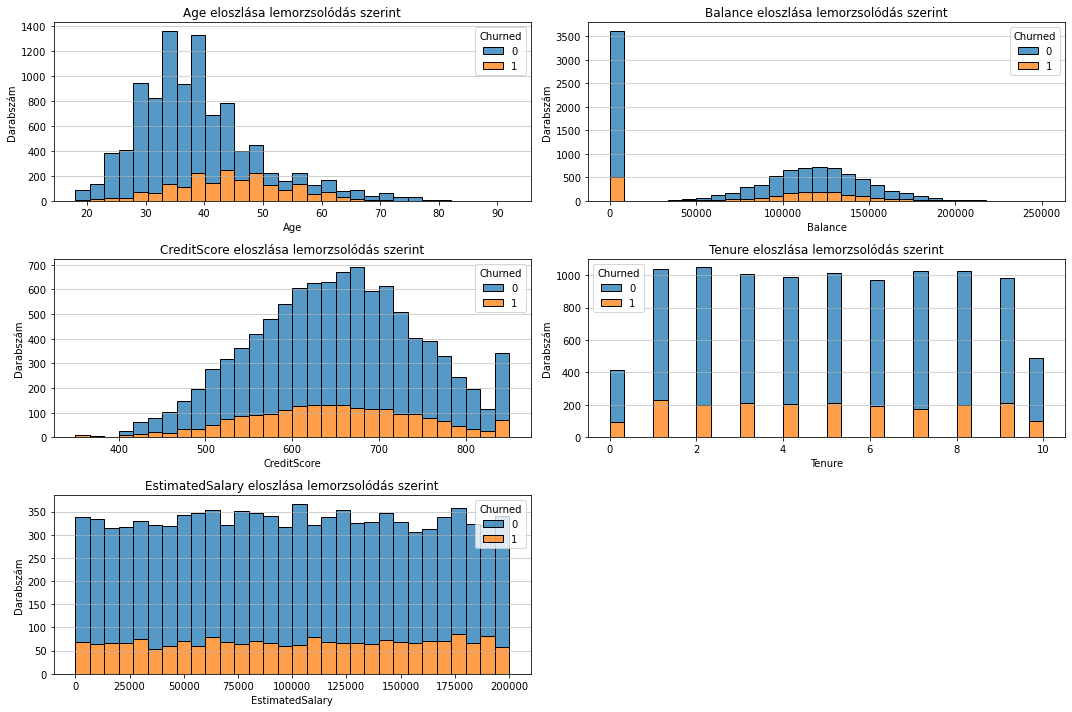

In [22]:
# Hisztogramok lemorzsolódás alapján
plt.figure(figsize=(15, 10))  # Ábra mérete
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 2, i)  # Több ábra egymás mellé rendezése
    sns.histplot(
        data=data_cleaned, 
        x=column, 
        hue="Churned", 
        multiple="stack", 
        bins=30, 
        kde=False,
    )
    plt.title(f"{column} eloszlása lemorzsolódás szerint")
    plt.xlabel(column)
    plt.ylabel("Darabszám")
    plt.grid(axis="y", alpha=0.75)  # Segédvonalak az Y tengelyen

plt.tight_layout()  # Az ábrák közötti távolság optimalizálása
plt.show()

#### Érdemes megvizsgálni a 3 legnagyobb abszolútértékű korrelációjú numerikus változó csoportosítva, hogy könyebben értelmezhetővé váljon

#### Lemorzsolódás vizsgálata kor (Age) alapján

Churn arány életkor csoportok szerint (%):
                        Not churned (%)  Churn (%)
AgeGroup                                          
Fiatal felnőtt (18-30)        92.443632   7.556368
Felnőtt (31-45)               85.562386  14.437614
Középkorú (46-60)             50.551268  49.448732
Idős (60+)                    71.946565  28.053435


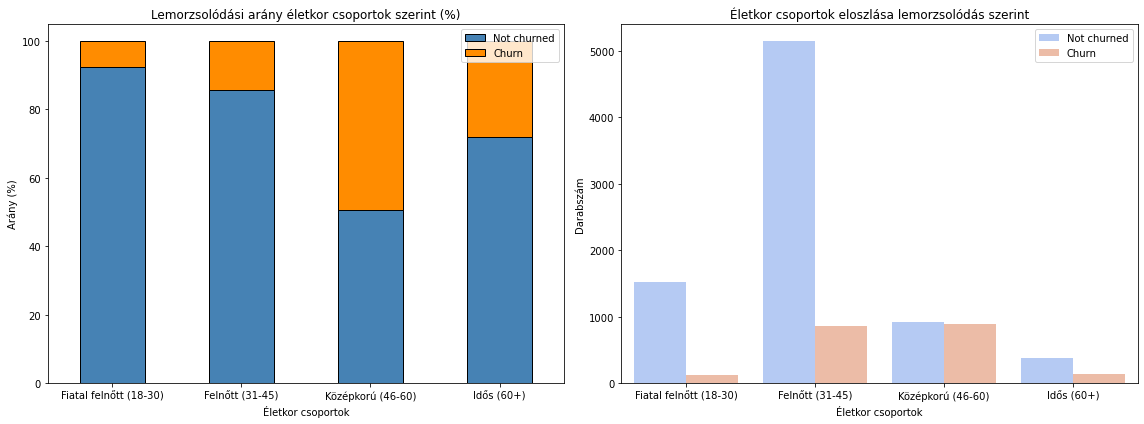

In [23]:
# Másolat készítése az adatról az életkor elemzéshez
data_age_grouped = data_cleaned.copy()

# Életkor csoportosítása kategóriákba
bins = [18, 30, 45, 60, data_age_grouped["Age"].max()]
labels = ["Fiatal felnőtt (18-30)", "Felnőtt (31-45)", "Középkorú (46-60)", "Idős (60+)"]
data_age_grouped["AgeGroup"] = pd.cut(data_age_grouped["Age"], bins=bins, labels=labels, right=False)

# Százalékos arány kiszámítása életkor csoportok és lemorzsolódás alapján
agegroup_churn_pct = data_age_grouped.groupby("AgeGroup")["Churned"].value_counts(normalize=True).unstack() * 100
agegroup_churn_pct.columns = ["Not churned (%)", "Churn (%)"]
print("Churn arány életkor csoportok szerint (%):")
print(agegroup_churn_pct)

# Rácsos elrendezés létrehozása az egymás melletti ábrákhoz
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Bal oldali ábra: Százalékos arány vizualizálása
agegroup_churn_pct.plot(kind="bar", stacked=True, ax=axes[0], color=["steelblue", "darkorange"], edgecolor="black")
axes[0].set_title("Lemorzsolódási arány életkor csoportok szerint (%)")
axes[0].set_xlabel("Életkor csoportok")
axes[0].set_ylabel("Arány (%)")
axes[0].legend(["Not churned", "Churn"], loc="upper right")
axes[0].tick_params(axis="x", rotation=0)  # Vízzintes tengelyfeliratok beállítása

# Jobb oldali ábra: Életkor csoportok vizualizálása darabszám alapján
sns.countplot(data=data_age_grouped, x="AgeGroup", hue="Churned", ax=axes[1], palette="coolwarm")
axes[1].set_title("Életkor csoportok eloszlása lemorzsolódás szerint")
axes[1].set_xlabel("Életkor csoportok")
axes[1].set_ylabel("Darabszám")
axes[1].legend(["Not churned", "Churn"], loc="upper right")
axes[1].tick_params(axis="x", rotation=0)  # Vízzintes tengelyfeliratok beállítása

# Automatikus elrendezés az ábrák között
plt.tight_layout()
plt.show()

A legnagyobb lemorzsolódás a egyértelműen a középkorú ügyfeleknél volt megfigyelhető, itt ez majdnem 50 százalék volt, ami igen jelentősnek mondható. Az idős vásárlókból bár kevesebb van, itt is viszonylag nagy, közel 30 százalékos a lemorzsolódás, a felnőtt kategóriába, ahová a legtöbb ügyfél tartozik, ott csak 14 százalék ez a mutató.

#### Lemorzsolódás vizsgálata egyenleg (Balance) alapján

Lemorzsolódási arány balance csoportok szerint (%):
                      Not churned (%)  Churn (%)
BalanceGroup                                    
Alacsony (<50K)             85.752979  14.247021
Közepes (50K-100K)          80.119284  19.880716
Magas (100K-150K)           74.229765  25.770235
Nagyon magas (150K+)        76.962810  23.037190


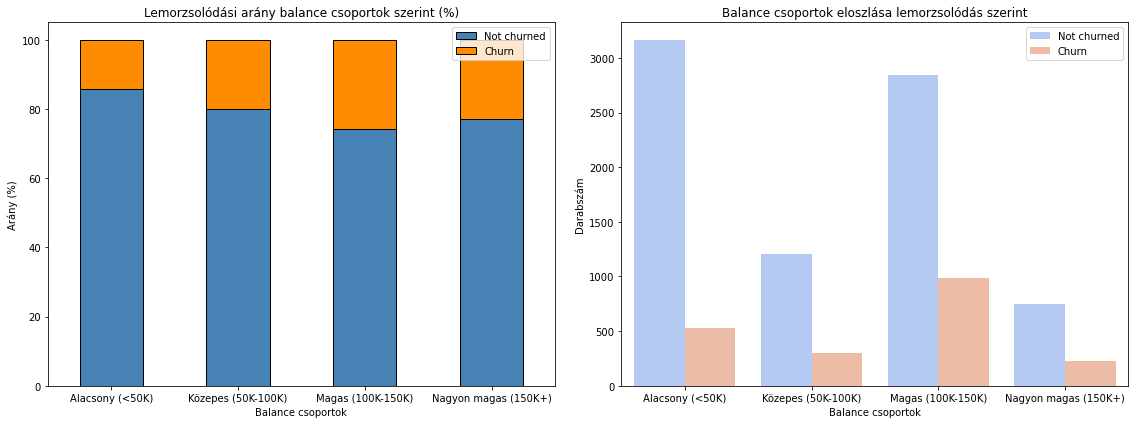

In [24]:
# Másolat készítése az adatról a balance elemzéshez
data_balance_grouped = data_cleaned.copy()

# Balance csoportosítása kategóriákba
balance_bins = [0, 50000, 100000, 150000, data_balance_grouped["Balance"].max()]
balance_labels = ["Alacsony (<50K)", "Közepes (50K-100K)", "Magas (100K-150K)", "Nagyon magas (150K+)"]
data_balance_grouped["BalanceGroup"] = pd.cut(data_balance_grouped["Balance"], bins=balance_bins, labels=balance_labels, right=False)

# Százalékos arány kiszámítása balance csoportok és lemorzsolódás alapján
balancegroup_churn_pct = data_balance_grouped.groupby("BalanceGroup")["Churned"].value_counts(normalize=True).unstack() * 100
balancegroup_churn_pct.columns = ["Not churned (%)", "Churn (%)"]
print("Lemorzsolódási arány balance csoportok szerint (%):")
print(balancegroup_churn_pct)

# Rácsos elrendezés létrehozása az egymás melletti ábrákhoz
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Bal oldali ábra: Százalékos arány vizualizálása
balancegroup_churn_pct.plot(kind="bar", stacked=True, ax=axes[0], color=["steelblue", "darkorange"], edgecolor="black")
axes[0].set_title("Lemorzsolódási arány balance csoportok szerint (%)")
axes[0].set_xlabel("Balance csoportok")
axes[0].set_ylabel("Arány (%)")
axes[0].legend(["Not churned", "Churn"], loc="upper right")
axes[0].tick_params(axis="x", rotation=0)  # Vízzintes tengelyfeliratok beállítása

# Jobb oldali ábra: Balance csoportok vizualizálása darabszám alapján
sns.countplot(data=data_balance_grouped, x="BalanceGroup", hue="Churned", ax=axes[1], palette="coolwarm")
axes[1].set_title("Balance csoportok eloszlása lemorzsolódás szerint")
axes[1].set_xlabel("Balance csoportok")
axes[1].set_ylabel("Darabszám")
axes[1].legend(["Not churned", "Churn"], loc="upper right")
axes[1].tick_params(axis="x", rotation=0)  # Vízzintes tengelyfeliratok beállítása

# Automatikus elrendezés az ábrák között
plt.tight_layout()
plt.show()


Az ábrák alapján a legmagasabb lemorzsolódási arány a Magas (100K–150K) és Nagyon magas (150K+) egyenleggel rendelkező ügyfelek körében figyelhető meg, ahol a lemorzsolódás aránya 25,77%, illetve 23,03%. Az alacsony egyenleggel rendelkezők (<50K) a legkevésbé hajlamosak a lemorzsolódásra, itt csupán 14,25% az arány. A Közepes (50K–100K) kategóriában kissé nagyobb a churn arány, de még mindig alacsonyabb (19,88%), mint a magasabb egyenlegű csoportokban.

Vagyis elmondható, hogy a magasabb egyenlegű ügyfelek kevésbé lojálisak, és nagyobb eséllyel hagyják el a bankot, míg az alacsonyabb egyenlegű ügyfelek stabilabb ügyfélkört alkotnak.

#### Lemorzsolódás vizsgálata kreditérték (CreditScore) alapján

Lemorzsolódási arány CreditScore csoportok szerint (%):
                     Not churned (%)  Churn (%)
CreditScoreGroup                               
Alacsony (350-500)         76.265823  23.734177
Közepes (500-650)          78.936270  21.063730
Magas(650-800)             80.652418  19.347582
Nagyon magas (800+)        80.458015  19.541985


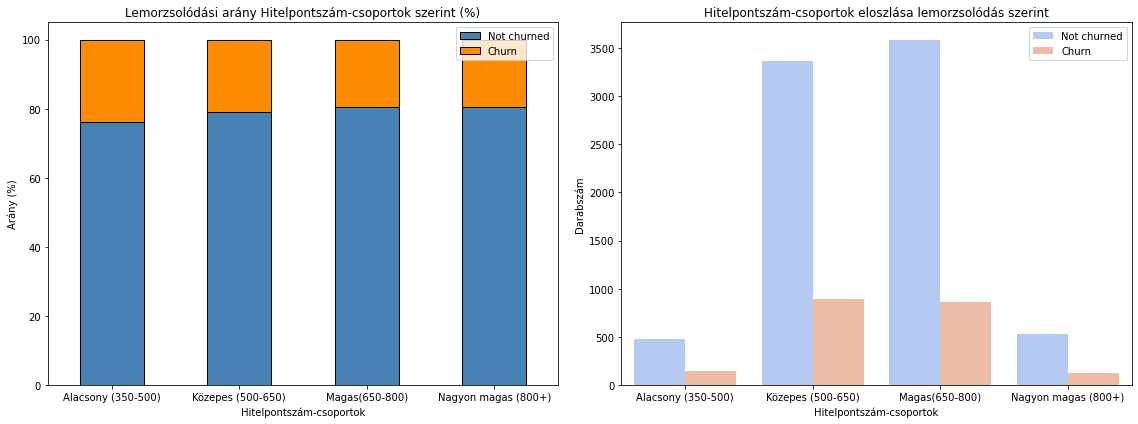

In [25]:
# Másolat készítése az adatról a CreditScore elemzéshez
data_creditscore_grouped = data_cleaned.copy()

# Minimum érték lekérése a CreditScore oszlopból
creditscore_min = data_creditscore_grouped["CreditScore"].min()

# CreditScore csoportosítása kategóriákba a minimum értéktől kezdve
creditscore_bins = [creditscore_min, 500, 650, 800, data_creditscore_grouped["CreditScore"].max() + 1]
creditscore_labels = ["Alacsony (350-500)", "Közepes (500-650)", "Magas(650-800)", "Nagyon magas (800+)"]
data_creditscore_grouped["CreditScoreGroup"] = pd.cut(data_creditscore_grouped["CreditScore"], bins=creditscore_bins, labels=creditscore_labels, right=False)

# Százalékos arány kiszámítása CreditScore csoportok és lemorzsolódás alapján
creditscoregroup_churn_pct = data_creditscore_grouped.groupby("CreditScoreGroup")["Churned"].value_counts(normalize=True).unstack(fill_value=0) * 100
creditscoregroup_churn_pct.columns = ["Not churned (%)", "Churn (%)"]
print("Lemorzsolódási arány CreditScore csoportok szerint (%):")
print(creditscoregroup_churn_pct)

# Rácsos elrendezés létrehozása az egymás melletti ábrákhoz
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Bal oldali ábra: Százalékos arány vizualizálása
creditscoregroup_churn_pct.plot(kind="bar", stacked=True, ax=axes[0], color=["steelblue", "darkorange"], edgecolor="black")
axes[0].set_title("Lemorzsolódási arány Hitelpontszám-csoportok szerint (%)")
axes[0].set_xlabel("Hitelpontszám-csoportok")
axes[0].set_ylabel("Arány (%)")
axes[0].legend(["Not churned", "Churn"], loc="upper right")
axes[0].tick_params(axis="x", rotation=0)  # Vízzintes tengelyfeliratok beállítása

# Jobb oldali ábra: CreditScore csoportok vizualizálása darabszám alapján
sns.countplot(data=data_creditscore_grouped, x="CreditScoreGroup", hue="Churned", ax=axes[1], palette="coolwarm")
axes[1].set_title("Hitelpontszám-csoportok eloszlása lemorzsolódás szerint")
axes[1].set_xlabel("Hitelpontszám-csoportok")
axes[1].set_ylabel("Darabszám")
axes[1].legend(["Not churned", "Churn"], loc="upper right")
axes[1].tick_params(axis="x", rotation=0)  # Vízzintes tengelyfeliratok beállítása

# Automatikus elrendezés az ábrák között
plt.tight_layout()
plt.show()

Látható, hogy itt a lemorzsolódási arányok minimálisan eltérőek, ami alátámasztja a korrelációs elemzésünk eredményét. Az ábrák alapján az alacsony hitelpontszámmal rendelkező ügyfelek (350–500) mutatják a legmagasabb lemorzsolódási arányt, ami 23,73%. A Közepes (500–650) és Magas (650–800) hitelpontszámú ügyfelek körében a lemorzsolódási arány csökken, 21,06%, illetve 19,35%. A Nagyon magas (800+) hitelpontszámú ügyfelek a legkevésbé hajlamosak lemorzsolódni, itt az arány mindössze 19,54%.

 ###### Modellépítés-és-kiértékelés

 <h1><center>Modellépítés és kiértékelés</center></h1>

In [26]:
# Jellemzők (X) és célváltozó (y) elkülönítése
X = data_cleaned.drop(columns=["Churned"])
y = data_cleaned["Churned"]

In [27]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_columns),  # Numerikus jellemzők skálázása
        ("cat", OneHotEncoder(), categorical_columns)  # Kategorikus jellemzők kódolása
    ]
)

In [28]:
# Modellek definiálása
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

## Keresztvalidáció a modellek teljesítményének összehasonlítására

A keresztvalidáció került alkalmazásra  a különböző modellek teljesítményének összehasonlítására, lehetővé téve az ügyféllemorzsolódás előrejelzésére leginkább alkalmas modell azonosítását.
Ezzel a módszerrel a modellek értékelése több metrika, például Recall és Accuracy (pontosság) értékek alapján történt, miközben az adathalmazra való túlilleszkedés kockázata csökkentve lett. Az eredmények alapján a legmegfelelőbb modell kerül kiválasztásra az üzleti prioritások figyelembevételével.

In [29]:
# Egyedi scorer az 1-es osztály recall értékére
def recall_class_1(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=1)

# Egyedi scorer definiálása
recall_scorer = make_scorer(recall_class_1)
accuracy_scorer = make_scorer(accuracy_score)

# Stratifikált kereszt-validáció
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [30]:
# Eredmények tárolása
cv_results = {}

# Kereszt-validáció a modellekhez
for model_name, model in models.items():
    # Pipeline létrehozása
    pipeline = Pipeline([
        ("preprocessor", preprocessor),  # Előfeldolgozás
        ("smote", SMOTE(random_state=42)),  # SMOTE oversampling
        ("classifier", model)  # Modell
    ])
    
    print(f"\nEvaluating {model_name}...")
    
    # Accuracy számítása
    accuracy_scores = cross_val_score(pipeline, X, y, cv=stratified_cv, scoring=accuracy_scorer, n_jobs=-1)
    mean_accuracy = np.mean(accuracy_scores)
    std_accuracy = np.std(accuracy_scores)
    
    # Recall (Class 1) számítása
    recall_scores = cross_val_score(pipeline, X, y, cv=stratified_cv, scoring=recall_scorer, n_jobs=-1)
    mean_recall = np.mean(recall_scores)
    std_recall = np.std(recall_scores)
    
    
    # Eredmények tárolása
    cv_results[model_name] = {
        "mean_accuracy": mean_accuracy,
        "std_accuracy": std_accuracy,
        "mean_recall": mean_recall,
        "std_recall": std_recall
    }
    
# Eredmények kiírása
print("")
print("\nKereszt-validációs eredmények:")
for model_name, results in cv_results.items():
    print(f"{model_name}: Mean Accuracy = {results['mean_accuracy']:.4f}, Std Dev = {results['std_accuracy']:.4f}")
    print(f"{model_name}: Mean Recall (Class 1) = {results['mean_recall']:.4f}, Std Dev = {results['std_recall']:.4f}")
    print("")


Evaluating Random Forest...

Evaluating SVM...

Evaluating Decision Tree...

Evaluating Gradient Boosting...

Evaluating K-Nearest Neighbors...

Evaluating Logistic Regression...


Kereszt-validációs eredmények:
Random Forest: Mean Accuracy = 0.8414, Std Dev = 0.0055
Random Forest: Mean Recall (Class 1) = 0.5759, Std Dev = 0.0211

SVM: Mean Accuracy = 0.7973, Std Dev = 0.0096
SVM: Mean Recall (Class 1) = 0.7163, Std Dev = 0.0273

Decision Tree: Mean Accuracy = 0.7783, Std Dev = 0.0102
Decision Tree: Mean Recall (Class 1) = 0.5523, Std Dev = 0.0206

Gradient Boosting: Mean Accuracy = 0.8395, Std Dev = 0.0085
Gradient Boosting: Mean Recall (Class 1) = 0.6647, Std Dev = 0.0310

K-Nearest Neighbors: Mean Accuracy = 0.7441, Std Dev = 0.0041
K-Nearest Neighbors: Mean Recall (Class 1) = 0.6485, Std Dev = 0.0115

Logistic Regression: Mean Accuracy = 0.7642, Std Dev = 0.0110
Logistic Regression: Mean Recall (Class 1) = 0.7457, Std Dev = 0.0100



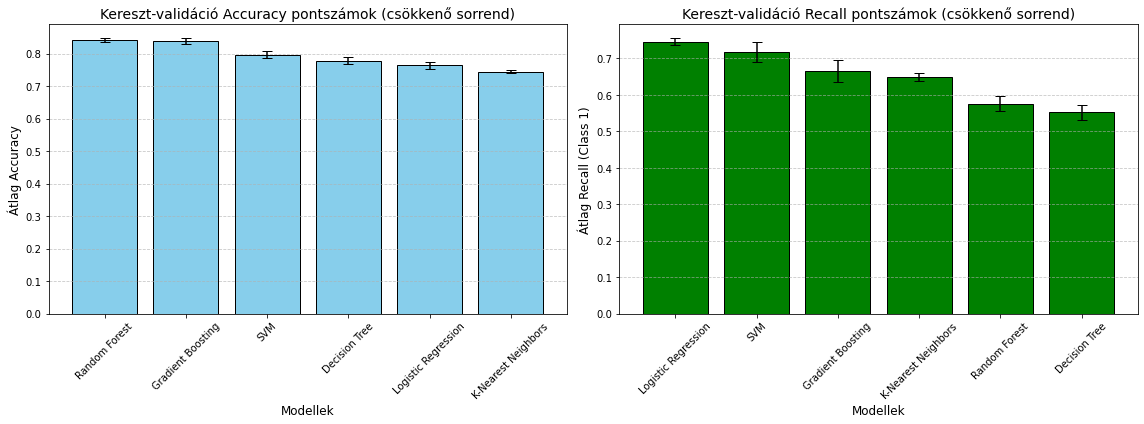

In [31]:
# Accuracy és Recall eredmények kibontása
model_names = list(cv_results.keys())
accuracy_mean_scores = [results["mean_accuracy"] for results in cv_results.values()]
accuracy_std_scores = [results["std_accuracy"] for results in cv_results.values()]
recall_mean_scores = [results["mean_recall"] for results in cv_results.values()]
recall_std_scores = [results["std_recall"] for results in cv_results.values()]

# Accuracy eredmények rendezése
accuracy_sorted_results = sorted(
    zip(model_names, accuracy_mean_scores, accuracy_std_scores),
    key=lambda x: x[1],  # Az átlag accuracy pontszám alapján rendezés
    reverse=True
)
sorted_accuracy_names, sorted_accuracy_means, sorted_accuracy_stds = zip(*accuracy_sorted_results)

# Recall eredmények rendezése
recall_sorted_results = sorted(
    zip(model_names, recall_mean_scores, recall_std_scores),
    key=lambda x: x[1],  # Az átlag recall pontszám alapján rendezés
    reverse=True
)
sorted_recall_names, sorted_recall_means, sorted_recall_stds = zip(*recall_sorted_results)



# Vizualizáció: Accuracy és Recall egymás mellett
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy pontszámok ábrázolása bal oldalon
axes[0].bar(sorted_accuracy_names, sorted_accuracy_means, yerr=sorted_accuracy_stds, capsize=5, 
            color="skyblue", edgecolor="black")
axes[0].set_title("Kereszt-validáció Accuracy pontszámok (csökkenő sorrend)", fontsize=14)
axes[0].set_ylabel("Átlag Accuracy", fontsize=12)
axes[0].set_xlabel("Modellek", fontsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Recall pontszámok ábrázolása jobb oldalon
axes[1].bar(sorted_recall_names, sorted_recall_means, yerr=sorted_recall_stds, capsize=5, 
            color="green", edgecolor="black")
axes[1].set_title("Kereszt-validáció Recall pontszámok (csökkenő sorrend)", fontsize=14)
axes[1].set_ylabel("Átlag Recall (Class 1)", fontsize=12)
axes[1].set_xlabel("Modellek", fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Layout beállítása
plt.tight_layout()
plt.show()

Bár az Accuracy fontos általános teljesítménymutató, az ügyféllemorzsolódás előrejelzésénél az üzleti prioritások miatt a Recall mutató kiemelt jelentőséggel bír, mivel a legfőbb cél az, hogy minél több távozó ügyfél kerüljön  pontosan beazonosításra, ezáltal pedig lehetőség legyen hatékony megtartási stratégiák kidolgozására. Ezen indokok miatt végül a Recall alapján lett kiválasztva a legjobban teljesítő modell.

A fenti ábra alapján látható, hogy az Accuracy (pontosság) szempontjából a Random Forest és a Gradient Boosting algoritmusok teljesítettek jobban, ami azt jelzi, hogy ezek a modellek általánosságban pontosabb predikciókat adnak. Azonban a Recall érték alapján, amely a ténylegesen lemorzsolódott ügyfelek helyes azonosítását méri, a Logistic Regression bizonyult a leghatékonyabbnak, így végül ez kerül további kidolgozásra.

## Recall alapján legjobban teljesítő modell (Logistic Regression) létrehozása

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1607
           1       0.69      0.36      0.48       393

    accuracy                           0.84      2000
   macro avg       0.77      0.66      0.69      2000
weighted avg       0.83      0.84      0.82      2000


ROC AUC Score: 0.8369


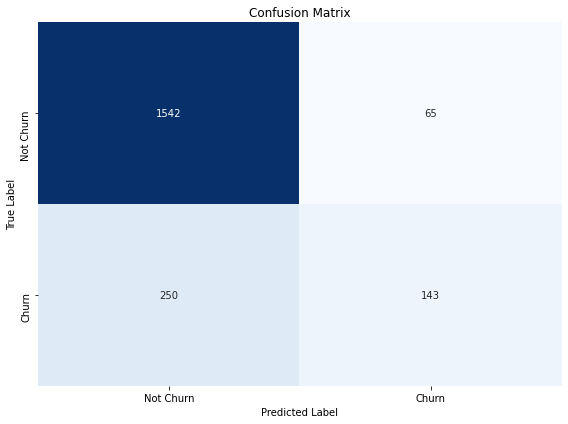

In [32]:
# Adatok szétosztása: tréning és teszt halmaz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression modell
model = LogisticRegression(
    max_iter=1000,  # Iterációk számának maximalizálása a konvergencia érdekében
    random_state=42
)

# Pipeline létrehozása
pipeline = Pipeline([
    ("preprocessor", preprocessor),  # Előfeldolgozás
    ("classifier", model)  # Logistic Regression modell
])

# Modell tanítása
pipeline.fit(X_train, y_train)

# Teszt eredmények kiértékelése
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Lemorzsolódás valószínűsége

conf_matrix = confusion_matrix(y_test, y_pred)

# Classification Report és ROC AUC kiírása
print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Konfúziós mátrix ábrázolása
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

A modell elkészítéséhez először szükség volt az adatok felosztására  tanuló és teszt adathalmazokra, hogy biztosítsuk a modell megfelelő értékelését új, még nem látott adatokon, ez a felosztás 80-20 arányban történt meg. Ezután a modell (Logistic regression) példányosítása után Pipeline segítségével lett feldolgozva az adat, ezeken a feldolgozott adatokon végzett tanítás során a modell megtanulta az ügyféllemorzsolódás mintázatait, készen állva a tesztadatok alapján történő teljesítményértékelésre.

A fenti ábrán látszik, hogy a modell teljesítménye még nem érte el az optimális szintet, mindössze 36% a Recall mutató értéke , ami elsősorban az adathalmaz kiegyensúlyozatlanságára vezethető vissza. A megmaradt ügyfelek jelentős túlsúlya miatt a modell nehezen tudta pontosan beazonosítani a lemorzsolódó ügyfeleket, ami különösen fontos lenne a recall javítása érdekében. <br>

Ennek az aránytalanságnak a kezelésére a SMOTE (Synthetic Minority Oversampling Technique) kerül alkalmazásra, amely kiegyenlíti az adathalmazt a kisebbségi osztály (lemorzsolódó ügyfelek) szintetikus mintáinak létrehozásával. Ez a technika nem egyszerű mintaismétlés, hanem az adatok mintázatai alapján interpolált új példák generálása, amely segíti a modell tanulását. A SMOTE révén a modell jobban felismeri a kisebbségi osztályt, javítva a recall értéket és a lemorzsolódási előrejelzések pontosságát.

##  Logistic Regression algoritmus SMOTE adatkiegyenlítéssel 

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1607
           1       0.45      0.76      0.56       393

    accuracy                           0.77      2000
   macro avg       0.69      0.77      0.70      2000
weighted avg       0.83      0.77      0.79      2000


ROC AUC Score: 0.8375


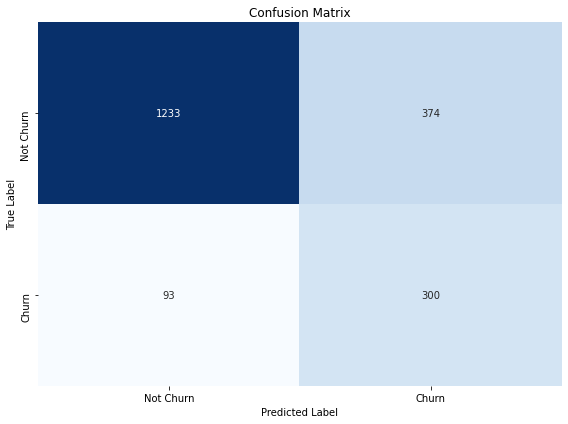

In [33]:
# Pipeline létrehozása SMOTE adatkiegyenlítéssel
pipeline = Pipeline([
    ("preprocessor", preprocessor),  # Előfeldolgozás
    ("smote", SMOTE(random_state=42)),  # SMOTE oversampling
    ("classifier", model)  # Decision Tree modell
])

# Modell tanítása
pipeline.fit(X_train, y_train)

# Teszt eredmények kiértékelése
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Lemorzsolódás valószínűsége

# Classification Report és ROC AUC kiírása
print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Konfúziós mátrix ábrázolása
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

A modell teljesítménye jelentős mértékben javult a SMOTE alkalmazását követően, a recall érték 36%-ról 76%-ra növekedett. Ez azt jelzi, hogy a modell sokkal hatékonyabbá vált a ténylegesen lemorzsolódó ügyfelek helyes azonosításában. <br>
További finomhangolással – például a paraméterek optimalizálásával – még jobb eredmények érhetők el.

## Paraméter-optimalizálás

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'classifier__C': 0.01, 'classifier__max_iter': 500, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.76      0.84      1607
           1       0.44      0.77      0.56       393

    accuracy                           0.76      2000
   macro avg       0.69      0.77      0.70      2000
weighted avg       0.83      0.76      0.78      2000




AUC: 0.8368


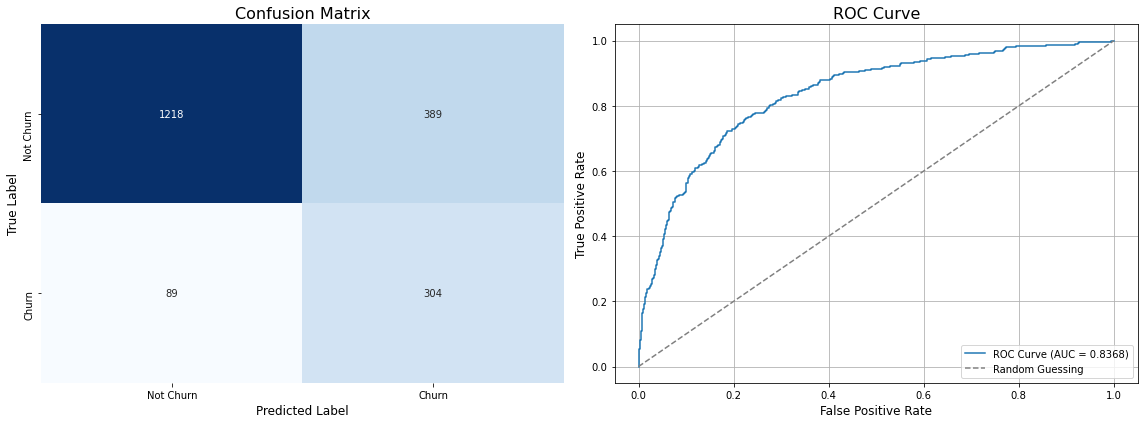

In [34]:
# Paraméterek rács alapú eloszlása Logistic Regression-hez
param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],  # Regularizációs paraméter (C)
    "classifier__penalty": ["l2"],  # Regularizáció típusa (csak "l2" támogatott szolvertől függően)
    "classifier__solver": ["lbfgs", "saga"],  # Szolvertípusok
    "classifier__max_iter": [500, 1000]  # Iterációk száma
}

# Logistic Regression modell
model = LogisticRegression(random_state=42)

# Pipeline létrehozása SMOTE-tal
pipeline = Pipeline([
    ("preprocessor", preprocessor),  # Előfeldolgozás
    ("smote", SMOTE(random_state=42)),  # SMOTE oversampling
    ("classifier", model)  # Logistic Regression modell
])

# GridSearchCV a pipeline-ra
grid_search = GridSearchCV(
    pipeline, 
    param_grid=param_grid, 
    cv=5, 
    scoring = recall_scorer, # Recall 1-es értékenek optimalizálása
    n_jobs=-1, 
    verbose=2
)

# Keresés futtatása
grid_search.fit(X_train, y_train)

# Legjobb paraméterek és pontszám
print(f"Best Parameters: {grid_search.best_params_}\n\n")

# Teszt eredmények kiértékelése
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]  # Lemorzsolódás valószínűsége

# ROC-görbe és AUC pontszám
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Eredmények kiértékelése
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\n\n")

print(f"AUC: {roc_auc:.4f}")



# Konfúziós mátrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Vizualizáció: ROC-görbe és konfúziós mátrix egymás mellett, ROC a jobb oldalon
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Konfúziós mátrix ábrázolása bal oldalon
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"], ax=axes[0])
axes[0].set_title("Confusion Matrix", fontsize=16)
axes[0].set_xlabel("Predicted Label", fontsize=12)
axes[0].set_ylabel("True Label", fontsize=12)

# ROC-görbe ábrázolása jobb oldalon
axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")
axes[1].set_title("ROC Curve", fontsize=16)
axes[1].set_xlabel("False Positive Rate", fontsize=12)
axes[1].set_ylabel("True Positive Rate", fontsize=12)
axes[1].legend(loc="lower right")
axes[1].grid(True)

# Layout beállítása
plt.tight_layout()
plt.show()

Az előző elemzések eredményeihez képest a finomhangolás után kis javulás figyelhető meg , a végső modell teljesítményének mutatói a következők lettek: pontosság (Accuracy) 76%, vagyis az összes ügyfélnek a 76%-át lett helyesen beazonosítva lemorzsolódás szerint, a Recall 77%, vagyis a ténylegesen lemorzsolódó ügyfelek több, mint háromnegyedét jelezte előre jól a modell, viszont a Precision 44%, vagyis a modell által lemorzsolódónak prediktált ügyfelek kevesebb, mint fele volt ténylegesen lemorzsolódó ügyfél. <br>

Ha a célkitűzés eltérő lett volna, például az általános pontosság (Accuracy) további növelése vagy a Precision optimalizálása, akkor más modell került volna kiválasztásra, illetve a modellépítés során más mutatók optimalizálása állt volna a középpontban. Ebben az esetben azonban a Recall mutató javítása volt az elsődleges cél, hiszen az üzleti szempontok szem előtt tartva a prioritás a ténylegesen lemorzsolódó ügyfeleket lehető legnagyobb arányú azonosítása volt. <br>

Ha a célkitűzés eltérő lett volna, például az általános pontosság (Accuracy) további növelése vagy a Precision optimalizálása, akkor más modell került volna kiválasztásra, illetve a modellépítés során más mutatók optimalizálása állt volna a középpontban, ebben az esetben azonban a Recall érték valószínűleg alacsonyabb lett volna. A dolgozat során azonban a Recall mutató javítása volt az elsődleges cél, hiszen az üzleti szempontokat szem előtt tartva a prioritás a ténylegesen lemorzsolódó ügyfelek lehető legnagyobb arányú azonosítása volt.

## Legjelentősebb változók hatása a modell kimenetelére

Az összes változó hatása a modell kimenetelére:
cat__NumOfProducts_2: -1.3339
cat__NumOfProducts_3+: 1.1823
num__Age: 0.7526
cat__Geography_Germany: 0.5224
cat__IsActiveMember_0: 0.4426
cat__IsActiveMember_1: -0.4426
cat__Geography_France: -0.3123
cat__Gender_Female: 0.2562
cat__Gender_Male: -0.2562
cat__Geography_Spain: -0.2101
cat__NumOfProducts_1: 0.1517
num__CreditScore: -0.0698
num__Tenure: -0.0392
num__EstimatedSalary: 0.0350
cat__HasCrCard_1: 0.0325
cat__HasCrCard_0: -0.0325
num__Balance: -0.0006


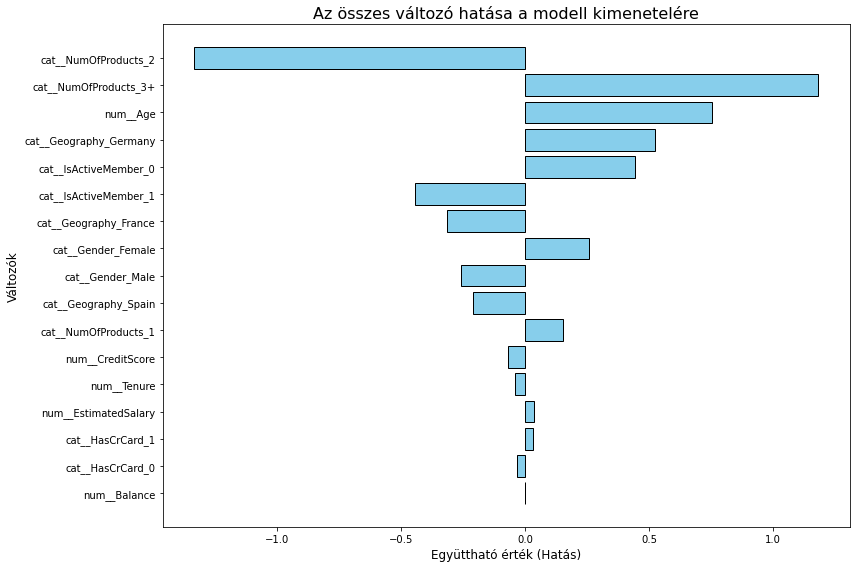

In [35]:
# Együtthatók kinyerése
coefficients = grid_search.best_estimator_.named_steps["classifier"].coef_[0]
feature_names = preprocessor.get_feature_names_out()

# Az együtthatók abszolút értéke alapján rendezett sorrend
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_feature_names = feature_names[sorted_indices]
sorted_coefficients = coefficients[sorted_indices]

# Az összes változó és hatás kiírása
print("Az összes változó hatása a modell kimenetelére:")
for feature, coefficient in zip(sorted_feature_names, sorted_coefficients):
    print(f"{feature}: {coefficient:.4f}")

# Az együtthatók és változók vizualizációja
plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names, sorted_coefficients, color="skyblue", edgecolor="k")
plt.title("Az összes változó hatása a modell kimenetelére", fontsize=16)
plt.xlabel("Együttható érték (Hatás)", fontsize=12)
plt.ylabel("Változók", fontsize=12)
plt.gca().invert_yaxis()  # A legnagyobb hatású változók legyenek felül
plt.tight_layout()
plt.show()

5 legjelentősebb változó hatása a modell kimenetelére:
cat__NumOfProducts_2: -1.3339
cat__NumOfProducts_3+: 1.1823
num__Age: 0.7526
cat__Geography_Germany: 0.5224
cat__IsActiveMember_0: 0.4426





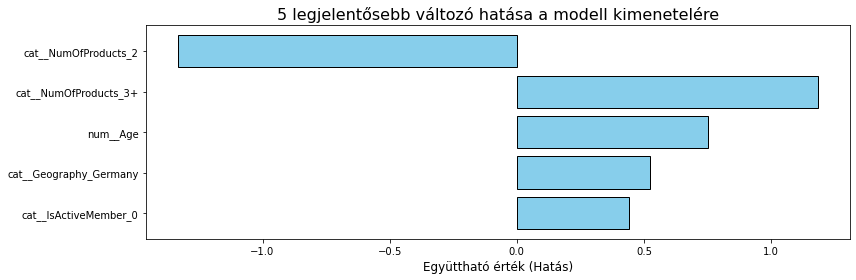

In [36]:
# Fontosságok (együtthatók) kinyerése
coefficients = grid_search.best_estimator_.named_steps["classifier"].coef_[0]  # Együtthatók
feature_names = preprocessor.get_feature_names_out()  # Változók nevei

# Változók és fontosságok rendezése abszolút érték alapján
indices = np.argsort(np.abs(coefficients))[::-1]
top_5_features = [(feature_names[i], coefficients[i]) for i in indices[:5]]

# Eredmények kiírása
print("5 legjelentősebb változó hatása a modell kimenetelére:")
for feature, importance in top_5_features:
    print(f"{feature}: {importance:.4f}")
print("\n\n")
    

# Top 5 változó vizualizálása
plt.figure(figsize=(12, 4))
plt.barh(
    [f[0] for f in reversed(top_5_features)], 
    [f[1] for f in reversed(top_5_features)], 
    color="skyblue", edgecolor="k"
)
plt.title("5 legjelentősebb változó hatása a modell kimenetelére", fontsize=16)
plt.xlabel("Együttható érték (Hatás)", fontsize=12)
plt.tight_layout()
plt.show()

A legjelentősebb változók hatásainak vizsgálata alapján megállapítható, hogy a modell kimenetelére a legerősebb befolyást a NumOfProducts változó gyakorolta. Ha egy ügyfél a "2 terméket használó" kategóriába tartozott, az csökkentette annak az valószínűségét, hogy a modell lemorzsolódónak prediktálja. Míg a "2 terméket használó" ügyfelek esetében ez a hatás pozitív volt, ami alapján a 3+ terméket használó kategóriába eső ügyfelek esetében nagyobb valószínűséggel jelezte előre a modell a lemorzsolódást. Ez arra utal, hogy a több terméket használó ügyfelek nagyobb kockázatot jelentenek a lemorzsolódás szempontjából, míg a két terméket használó ügyfelek stabilabb, hűségesebb csoportot alkothatnak.  <br>

Az életkor (Age) szintén jelentős tényező volt, pozitív irányú hatása arra utal, hogy az idősebb ügyfelek esetében nagyobb a lemorzsolódás valószínűsége.
A földrajzi elhelyezkedés közül Geography_Germany (Németország) kategóriája szintén pozitívan hatott a lemorzsolódásra, indikálva, hogy a német ügyfelek hajlamosabbak a távozásra.
Végül az IsActiveMember változó „inaktív” kategóriájába tartozás szintén emelte a lemorzsolódás valószínűségét.<br>

Az itt kapott eredmények teljes mértékben alátámasztják a korábban elvégzett vizualizációk és statisztikai elemzések megállapításait. Különösen jól kirajzolódik, hogy a termékhasználat (például a "3+" termékkategória), az ügyfelek életkora, a földrajzi elhelyezkedés (például Németország), valamint az aktivitás (vagy annak hiánya) mind olyan kulcsfontosságú tényezők, amelyek jelentős hatást gyakorolnak a lemorzsolódás előrejelzésére. Az eredmények megerősítik, hogy ezek a változók központi szerepet játszanak az ügyfélmegtartási stratégiák megtervezésében és végrehajtásában, így ezekre javasolt nagyobb hangsúlyt fektetni.

###### Összefoglalás-konklúzió

<h1><center>Összefoglalás és konklúzió</center></h1>

A banki ügyféllemorzsolódás elemzése és előrejelzése során a vizsgálatok rámutattak, hogy a lemorzsolódást leginkább befolyásoló tényezők közé tartozik az ügyfél által használt termékek száma, az életkor, az aktivitási státusz, valamint a földrajzi elhelyezkedés. Az elemzések során azonosítottuk, hogy az idősebb, három vagy több terméket használó, inaktív, illetve németországi ügyfelek nagyobb valószínűséggel hagyják el a bankot, ezek a tényezők mind növelik a lemorzsolódás valószínűségét.

A gépi tanulási modellek közül a Logistic Regression, SMOTE adatkiegyenlítéssel kombinálva bizonyult a leghatékonyabbnak a lemorzsolódás pontos előrejelzésében a Recall érték alapján. Ez kiemelten fontos az üzleti stratégia szempontjából, mivel a cél a lemorzsolódó ügyfelek pontos beazonosítása, hogy hatékony megtartási stratégiák legyenek kialakíthatók.

Az eredmények alátámasztják, hogy a prediktív modellezés alkalmazása nemcsak azonosítja a lemorzsolódás szempontjából leginkább  veszélyeztetett ügyfeleket, hanem iránymutatást is nyújt a megtartási stratégiák optimalizálásához. A kulcsfontosságú tényezők, például az ügyfelek aktivitásának ösztönzése, a német ügyfelekre szabott marketing, valamint a termékkínálat rugalmasabbá tétele központi szerepet játszhatnak a lemorzsolódási arány csökkentésében, az ügyfelek megtartásában és hűségük növelésében.